<a href="https://colab.research.google.com/github/WoradeeKongthong/training_MaskRCNN_for_taxi_detection/blob/main/training_MaskRCNN_for_taxi_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Mask R-CNN Object Detection 

## Create Mask R-CNN model for training

### Clone Mast-RCNN model with Tensorflow2

In [1]:
import os
if not os.path.isdir("./Mask-RCNN-TF2") :
  # !git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git
  ! git clone https://github.com/WoradeeKongthong/Mask-RCNN-TF2.git

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1438, done.
remote: Counting objects: 100% (1438/1438), done.
remote: Compressing objects: 100% (629/629), done.
remote: Total 1438 (delta 806), reused 1431 (delta 800), pack-reused 0
Receiving objects: 100% (1438/1438), 144.53 MiB | 32.76 MiB/s, done.
Resolving deltas: 100% (806/806), done.


### Install packages

In [2]:
!pip install -r Mask-RCNN-TF2/requirements.txt

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 377 kB 56.1 MB/s 
     |████████████████████████████████| 2.9 MB 58.7 MB/s 
     |████████████████████████████████| 3.0 MB 56.2 MB/s 
     |████████████████████████████████| 454 kB 76.3 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
     |████████████████████████████████| 391 kB 66.3 MB/s 
     |████████████████████████████████| 154 kB 74.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting 

### Import additional packages

In [3]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path

### Import mrcnn

In [4]:
# set root directory to Mask_RCNN
ROOT_DIR = 'Mask-RCNN-TF2'

# add root dir to path
sys.path.append(ROOT_DIR) 

# import mrcnn
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

Using TensorFlow backend.


### Get class names of COCO dataset

In [5]:
# load the class label names from disk, one label per line
CLASS_NAMES = open(ROOT_DIR+"/samples/coco_labels.txt").read().strip().split("\n")

### Load trained weights

In [6]:
# Local path to save trained weights file
COCO_MODEL_PATH = os.path.join('.', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


### Create model

In [21]:
# define a configuration for the model
class trainConfig(Config):
  
  # define the name of the configuration
  NAME = 'taxi_cfg' # don't change

  # number of classes (background + taxi)
  NUM_CLASSES = 1 + 1

  # number of training steps per epoch
  STEPS_PER_EPOCH = 10

In [22]:
config = trainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [23]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.getcwd(), "logs")

# define model
model = mrcnn.model.MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)

In [24]:
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Prepare dataset

### Clone my repository for dataset (images and annotations)

In [11]:
if not os.path.isdir("training_MaskRCNN_for_taxi_detection") :
  !git clone https://github.com/WoradeeKongthong/training_MaskRCNN_for_taxi_detection.git

Cloning into 'training_MaskRCNN_for_taxi_detection'...
remote: Enumerating objects: 3174, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 3174 (delta 0), reused 257 (delta 0), pack-reused 2917
Receiving objects: 100% (3174/3174), 515.25 MiB | 39.74 MiB/s, done.
Checking out files: 100% (3073/3073), done.


In [12]:
dataset_dir = '/content/training_MaskRCNN_for_taxi_detection/Dataset'

### Develop Mask R-CNN Dataset for taxi

In [13]:
class taxiDataset(Dataset):
  
  # load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
    """
    Load the dataset definitions : image id, image path and annotation path
    """

    # define one class to train
    self.add_class("dataset", 1, "taxi")
    
    # define image and annotation locations
    if is_train==True:
      # define location for training set
      images_dir = dataset_dir + '/train/Taxi/'
      annotations_dir = dataset_dir + '/train/Taxi/Label/'
    else :
      # define location for validation set
      images_dir = dataset_dir + '/validation/Taxi/'
      annotations_dir = dataset_dir + '/validation/Taxi/Label/'

    # find all images
    image_list = os.listdir(images_dir)
    image_list.remove('Label')
    for filename in image_list:

      # extract image id
      image_id = filename[:-4]
      
      # extract paths
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.txt'

      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def extract_boxes(self, filename):
    """
    - extract bounding boxes from an annotation file
    """
    
    # define list of boxes
    boxes = []

    # open the txt annotation file and read the information
    with open(filename) as file:
      temp = file.read().splitlines()

    # extract each box from each line
    for line in temp:
      box = list(map(float, line.split()[1:]))
      boxes.append(box)

    return boxes
  
  def load_mask(self, image_id):
    """
    load the mask of an image
    """

    # get details of image
    info = self.image_info[image_id]

    # define image file location
    img_path = info['path']

    # load image and get its dimensions
    img = load_img(img_path)
    w = img.width
    h = img.height
    
    # define annotation file location
    ann_path = info['annotation']

    # load boxes
    boxes = self.extract_boxes(ann_path)

    # create mask manually 
    # since our dataset has only bounding boxes 
    # we'll then generate rectangle mask from the boxes

    # create one array for all masks, each on a different channel
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    # create masks and class id
    class_ids = []
    for i,box in enumerate(boxes):
      row_s, row_e = int(box[1]), int(box[3])
      col_s, col_e = int(box[0]), int(box[2])
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('taxi'))
    
    return masks, np.asarray(class_ids, dtype='int32')
  
  def image_reference(self, image_id):
    """
    load an image reference
    """
    info = self.image_info[image_id]
    return info['path']

In [14]:
# create train set
train_set = taxiDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()

# create validation set
validation_set = taxiDataset()
validation_set.load_dataset(dataset_dir, is_train=False)
validation_set.prepare()

print('Train : ', len(train_set.image_ids))
print('Validation : ', len(validation_set.image_ids))
print('class_names : ', train_set.class_names)
print('class_info : ', train_set.class_info)

Train :  1434
Validation :  32
class_names :  ['BG', 'taxi']
class_info :  [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'dataset', 'id': 1, 'name': 'taxi'}]


### Example of annotation on image

In [15]:
# get random image_id from training set
image_id = random.choice(train_set.image_ids)

# load an image
image = train_set.load_image(image_id)

# load image mask
mask, class_ids = train_set.load_mask(image_id)

#### Plot with matplotlib

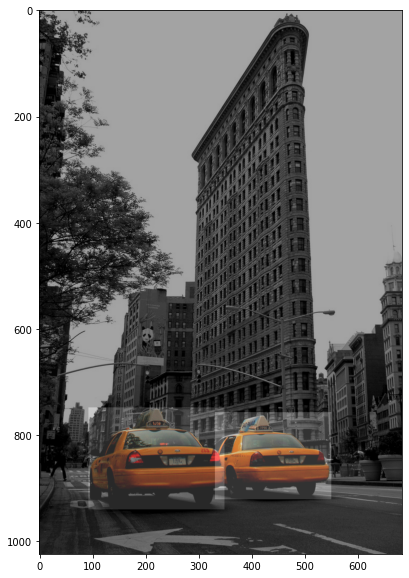

image_info :  {'id': '025186ac57d4e484', 'source': 'dataset', 'path': '/content/training_MaskRCNN_for_taxi_detection/Dataset/train/Taxi/025186ac57d4e484.jpg', 'annotation': '/content/training_MaskRCNN_for_taxi_detection/Dataset/train/Taxi/Label/025186ac57d4e484.txt'}
class_ids :  [1 1]
class names :  ['taxi', 'taxi']


In [25]:
# plot image
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

# plot mask
for i in range(mask.shape[2]):
  plt.imshow(mask[:,:,i], cmap='gray', alpha=0.2)

plt.show()
print('image_info : ', train_set.image_info[image_id])
print('class_ids : ', class_ids)
print('class names : ', [train_set.class_names[id] for id in class_ids])

#### Plot with mrcnn.visualize.display_instances

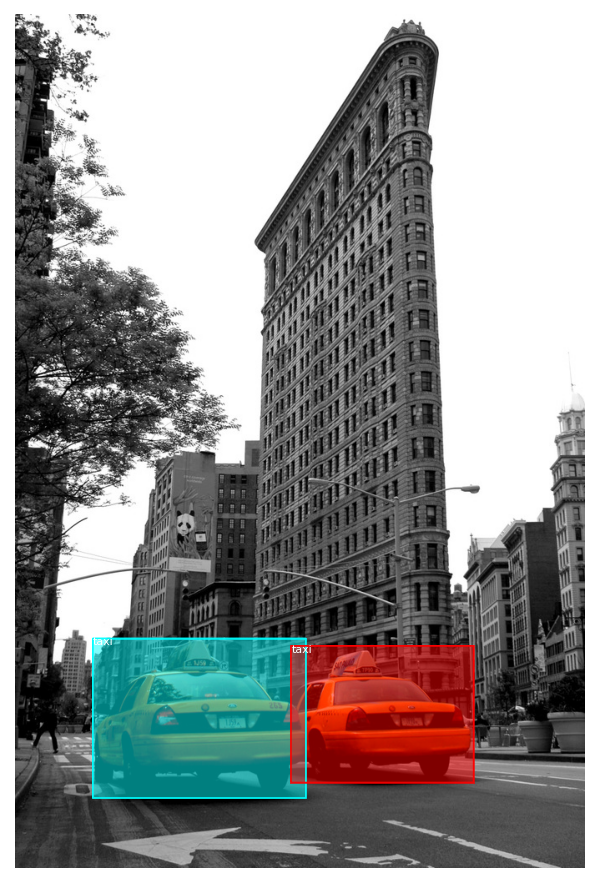

In [26]:
# extract bounding boxes
bbox = extract_bboxes(mask)

# display image with masks and bboxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

## Train the model

In [25]:
# train weights (output layers or 'heads')
model.train(train_set, validation_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/taxi_cfg20211017T1332/mask_rcnn_taxi_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
 2/10 [=====>........................] - ETA: 2:06 - loss: 3.1682

/usr/local/lib/python3.7/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.488076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


10/10 [==============================] - 91s 9s/step - loss: 2.1085 - val_loss: 1.4548
Epoch 2/20
10/10 [==============================] - 33s 3s/step - loss: 1.1165 - val_loss: 1.5519
Epoch 3/20
10/10 [==============================] - 32s 3s/step - loss: 1.0910 - val_loss: 1.3002
Epoch 4/20
10/10 [==============================] - 32s 3s/step - loss: 0.9443 - val_loss: 1.0304
Epoch 5/20
10/10 [==============================] - 33s 3s/step - loss: 1.2650 - val_loss: 2.1798
Epoch 6/20
10/10 [==============================] - 32s 3s/step - loss: 0.6844 - val_loss: 0.4908
Epoch 7/20
10/10 [==============================] - 32s 3s/step - loss: 1.1282 - val_loss: 1.2661
Epoch 8/20
10/10 [==============================] - 32s 3s/step - loss: 0.7410 - val_loss: 2.5142
Epoch 9/20
10/10 [==============================] - 31s 3s/step - loss: 1.0142 - val_loss: 0.8377
Epoch 10/20
10/10 [==============================] - 31s 3s/step - loss: 0.9508 - val_loss: 1.6934
Epoch 11/20
10/10 [===========

## Make prediction

In [26]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.model import log

In [27]:
# Create prdiction config
class PredictionConfig(Config):
    NAME = 'taxi_cfg'
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = PredictionConfig()

In [28]:
# Recreate the model in inference mode
model = mrcnn.model.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/logs/taxi_cfg20211017T1332/mask_rcnn_taxi_cfg_0020.h5
Re-starting from epoch 20


### Get ground truth from random image in test set

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  542.00000  max:  684.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


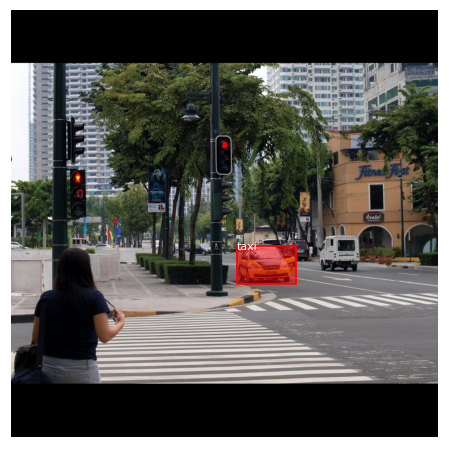

In [34]:
image_id = random.choice(validation_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(validation_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

mrcnn.visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

### Detection result

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


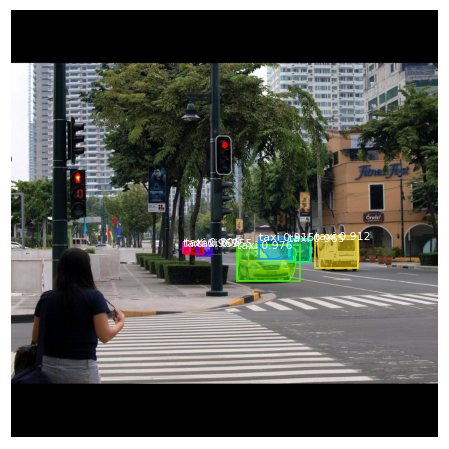

In [35]:
results = model.detect([original_image], verbose=1)

r = results[0]
mrcnn.visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            validation_set.class_names, r['scores'], figsize=(8, 8))

## Model Evaluation

In [37]:
APs = []
for image_id in validation_set.image_ids:

  # load ground truth
  image, _, gt_class_id, gt_bbox, gt_mask = load_image_gt(validation_set, config, image_id, use_mini_mask=False)

  # convert pixel values
  scaled_image = mold_image(image, config)

  # convert into one sample batch
  sample = np.expand_dims(scaled_image, 0)

  # make prediction
  results = model.detect(sample, verbose=0)

  # extract results for first sample
  r = results[0]

  # calculate statistics
  AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                                 r['rois'], r['class_ids'], r['scores'], r['masks'])
  
  # append to APs
  APs.append(AP)

# calculate mean AP 
mAP = np.mean(APs)

print('Model mAP : ', mAP)

Model mAP :  0.7297776892253777
